# Cat vs Dogs


## Librerías
- Instalación de librerías y módulos
- Carga de librerías y módulos


In [ ]:
!pip install fastai==1.0.61

In [2]:
import os
import PIL.Image
import numpy as np
from shutil import copy
from pathlib import Path
from random import randint, shuffle, seed

from fastai.vision import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se define una función para garantizar la reproducibilidad de los resultados.

In [3]:
def random_seed(seed_value):
    seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
random_seed(SEED)

Se instancian variables comunes.

In [4]:
lr = 1e-02
EPOCHS = 20
metrics = [error_rate,accuracy]

## MNIST
Descargue el conjunto de datos `MNIST` y en particular cree un modelo para **clasificar los números 1 y 7** usando una `resnet18` en `fastai`.

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-MNIST-Dataset.png"
     alt="MNIST"
     style="float: left; margin-right: 10px;" />

¿Cuál fue la precisión usando solo 30 imágenes de c/u, obtuvo una mejor precisión usando ahora 50 imágenes por número?

### Carga Datos
Se descargaron los datos haciendo uso de la API de fastai para descargar datasets públicos.

In [22]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

Se verifican los subdirectorios de los datos descargados.

In [23]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

Se verifica el subdirectorio de training, del cual se extraerán los números a clasificar *i.e.* `1s` & `7s`.

In [24]:
(path/'training/').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/4')]

In [25]:
(path/'testing/').ls()

[PosixPath('/root/.fastai/data/mnist_png/testing/6'),
 PosixPath('/root/.fastai/data/mnist_png/testing/1'),
 PosixPath('/root/.fastai/data/mnist_png/testing/7'),
 PosixPath('/root/.fastai/data/mnist_png/testing/5'),
 PosixPath('/root/.fastai/data/mnist_png/testing/8'),
 PosixPath('/root/.fastai/data/mnist_png/testing/9'),
 PosixPath('/root/.fastai/data/mnist_png/testing/2'),
 PosixPath('/root/.fastai/data/mnist_png/testing/3'),
 PosixPath('/root/.fastai/data/mnist_png/testing/0'),
 PosixPath('/root/.fastai/data/mnist_png/testing/4')]

Se definió una función para llevar a cabo la carga de los ejemplos necesarios para cada ejemplo

In [26]:
def dump_files(path:Path, n_train:int, labels:list = ['1','7'], base_dirs:list=['training','testing']) -> Path:
    n_test = int(n_train*0.3)

    for dir in base_dirs:
        for num in labels:
            num_parent_dir = path/str(dir)/str(num)
            num_dirs = num_parent_dir.ls()
            shuffle(num_dirs)

            dump_parent = Path(f"{path}/samples_{n_train}")
            dump_child = Path(f"{dump_parent}/{dir}/{num}")

            if dir =="training":
                sel_files = num_dirs[0:n_train]
            else:
                sel_files = num_dirs[0:n_test]

            if not os.path.isdir(dump_child):
                os.makedirs(dump_child)
            else:
                pass
            if len(dump_child.ls()) > 0:
                pass
            else:
                for i in sel_files:
                    shutil.copy(i, dump_child)


    return dump_parent

### Modelo 1
|Característica        |Descripción|
|----------------------|-----------|
|Modelo                |Resnet18   |
|Imágenes Entrenamiento|60         |
|Fracción test         |30%        |

Se identifican el número de imágenes de entrenamiento y validación:

In [27]:
n_train = 30
random_seed(SEED)

Del directorio de entrenamiento se extrajeron 30 ejemplos de cada una de las clases especificadas anteriormente.

In [28]:
path_30 = dump_files(path,n_train)
print(path_30)

/root/.fastai/data/mnist_png/samples_30


In [29]:
train_dir = path_30/"training"
test_dir = path_30/"testing"

In [30]:
print(f"Training set\nOnes: {len((train_dir/'1').ls())} examples\nSevens: {len((train_dir/'7').ls())} examples\n")
print(f"Testing set\nOnes: {len((test_dir/'1').ls())} examples\nSevens: {len((test_dir/'7').ls())} examples")

Training set
Ones: 30 examples
Sevens: 30 examples

Testing set
Ones: 9 examples
Sevens: 9 examples


In [31]:
data_30 = ImageDataBunch.from_folder(path_30,train="training",valid="testing",seed=SEED,bs=16,num_workers=4).normalize(imagenet_stats)

In [32]:
print(f"Distinct classes: {data_30.classes}\nCount Distinct classes: {data_30.c}\nTraining Examples: {len(data_30.train_ds)}\nValidation examples: {len(data_30.valid_ds)}")

Distinct classes: ['1', '7']
Count Distinct classes: 2
Training Examples: 60
Validation examples: 18


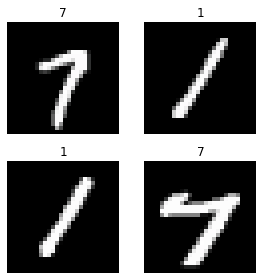

In [33]:
data_30.show_batch(rows=2, figsize=(4,4))

#### Entrenamiento

In [34]:
learn_30 = cnn_learner(data_30, models.resnet18, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [35]:
learn_30.fit(EPOCHS,slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.738063,1.582864,0.333333,0.666667,00:00
1,1.177894,2.347204,0.500000,0.500000,00:00
2,0.900685,0.709290,0.222222,0.777778,00:00
3,0.826912,0.436955,0.111111,0.888889,00:00
4,0.725466,0.350967,0.111111,0.888889,00:00
5,0.639072,0.112388,0.055556,0.944444,00:00
6,0.578276,0.033261,0.000000,1.000000,00:00
7,0.543057,0.232435,0.166667,0.833333,00:00
8,0.527731,0.743631,0.111111,0.888889,00:00
9,0.464798,0.716980,0.111111,0.888889,00:00


Se obtuvo una precisión del ~83%. No obstante, pudo definirse un criterio de early stopping para detener el entrenamiento cuando se encontraba una precisión del ~94%.

### Modelo 2
|Característica        |Descripción|
|----------------------|-----------|
|Modelo                |Resnet18   |
|Imágenes Entrenamiento|100        |
|Fracción test         |30%        |

In [36]:
n_train = 50
random_seed(SEED)

In [37]:
path_50 = dump_files(path,n_train)
print(path_50)

/root/.fastai/data/mnist_png/samples_50


In [38]:
train_dir = path_50/"training"
test_dir = path_50/"testing"

In [39]:
print(f"Training set\nOnes: {len((train_dir/'1').ls())} examples\nSevens: {len((train_dir/'7').ls())} examples\n")
print(f"Testing set\nOnes: {len((test_dir/'1').ls())} examples\nSevens: {len((test_dir/'7').ls())} examples")

Training set
Ones: 50 examples
Sevens: 50 examples

Testing set
Ones: 15 examples
Sevens: 15 examples


In [40]:
data_50 = ImageDataBunch.from_folder(path_50,train="training",valid="testing",seed=SEED,bs=16,num_workers=4).normalize(imagenet_stats)

In [41]:
print(f"Distinct classes: {data_50.classes}\nCount Distinct classes: {data_50.c}\nTraining Examples: {len(data_50.train_ds)}\nValidation examples: {len(data_50.valid_ds)}")

Distinct classes: ['1', '7']
Count Distinct classes: 2
Training Examples: 100
Validation examples: 30


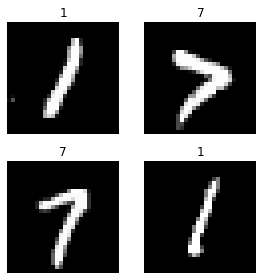

In [42]:
data_50.show_batch(rows=2, figsize=(4,4))

#### Entrenamiento

In [43]:
learn_50 = cnn_learner(data_50, models.resnet18, metrics=metrics)

In [44]:
learn_50.fit(EPOCHS, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.849060,4.153708,0.466667,0.533333,00:00
1,1.515610,0.333271,0.133333,0.866667,00:00
2,1.136972,0.843495,0.266667,0.733333,00:00
3,0.882469,0.414904,0.166667,0.833333,00:00
4,0.719486,0.240898,0.100000,0.900000,00:00
5,0.618560,0.059993,0.033333,0.966667,00:00
6,0.517531,0.317414,0.033333,0.966667,00:00
7,0.465452,0.777795,0.100000,0.900000,00:00
8,0.417610,0.639598,0.100000,0.900000,00:00
9,0.357265,0.646147,0.066667,0.933333,00:00


Se apreció una precisión mayor comparado con el del modelo 1, ~10% mayor que este.

### Comparación Modelos
Ambos modelos se entrenaron con una tasa de aprendizaje constante y número de epochs igual con el propósito.

>**Disclaimer:** Lo declarado a continuación puede no ser totalmente acertado dada la incapacidad de reducir la variación en los resultados.

#### Tasa de Aprendizaje

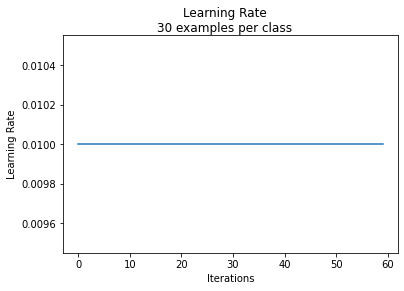

In [45]:
lr_30 = learn_30.recorder.plot_lr(return_fig=True)
lr_30.suptitle('Learning Rate\n30 examples per class')
plt.show()

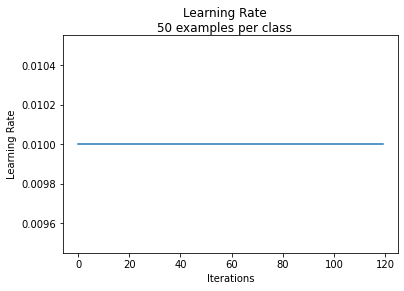

In [46]:
lr_50 = learn_50.recorder.plot_lr(return_fig=True)
lr_50.suptitle('Learning Rate\n50 examples per class')
plt.show()

Para ambos modelos no se aprecia cambios en la tasa de aprendizaje ya que esta se fijo a un valor constante:

$$l_r = 1*10^{-2}$$

#### Tasa de error - Precisión

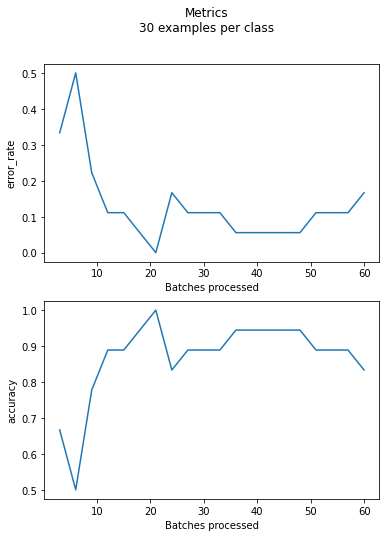

In [47]:
m_30 = learn_30.recorder.plot_metrics(return_fig=True)
m_30.suptitle('Metrics\n30 examples per class')
plt.show()

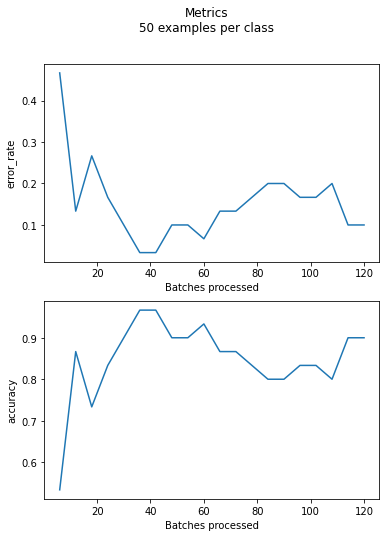

In [48]:
m_50 = learn_50.recorder.plot_metrics(return_fig=True)
m_50.suptitle('Metrics\n50 examples per class')
plt.show()

|Métrica|Comentario|
|-------|----------|
|Error rate|No se encontró una tendencia similar en ambos modelos, donde la variable actual tiende a descender y, posteriormente, a incrementar su valor.|
|Error rate|En ambos casos pudo definirse un criterio de early stopping en el que se detuviera el entrenamiento una vez la tasa de error incrementáse su valor.|
|Accuracy|De acuerdo con el comentario anterior se encontró un máximo al inicio del entrenamiento.|
|Accuracy|Ambos modelos fluctuaron un ~10% por encima o por debajo de una línea base al final del entrenamiento.|

Cabe resaltar que el modelo 2 mostró una mayor precisión respecto al apreciado en el modelo 1. Hecho que se adjudica al mayor número de ejemplos usados para el entrenamiento.


#### Pérdida

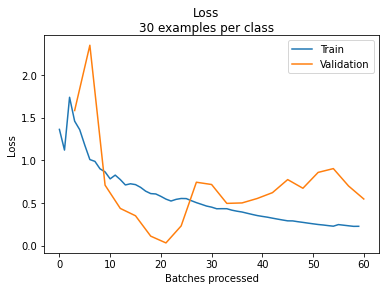

In [49]:
l_30 = learn_30.recorder.plot_losses(return_fig=True)
l_30.suptitle('Loss\n30 examples per class')
plt.show()

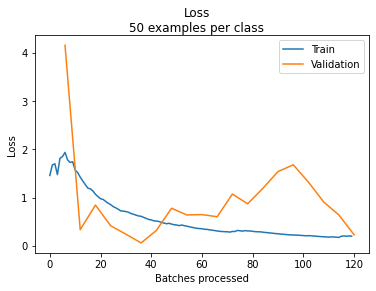

In [50]:
l_50 = learn_50.recorder.plot_losses(return_fig=True)
l_50.suptitle('Loss\n50 examples per class')
plt.show()

Ambas pérdidas (Train, Validation) tienden al mismo valor a lo largo del entrenamiento. Por lo tanto, ambos modelos se consideran como modelos de bajo sesgo.

#### Matriz de Confusión

In [51]:
interp_30 = ClassificationInterpretation.from_learner(learn_30)
interp_50 = ClassificationInterpretation.from_learner(learn_50)

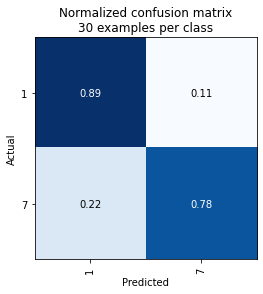

In [52]:
cm_30 = interp_30.plot_confusion_matrix(normalize=True, return_fig=True,title="Normalized confusion matrix\n30 examples per class")
plt.show()

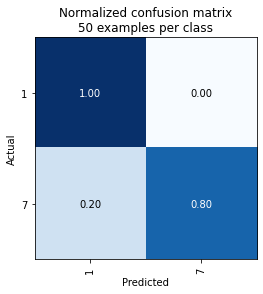

In [53]:
cm_50 = interp_50.plot_confusion_matrix(normalize=True, return_fig=True,title="Normalized confusion matrix\n50 examples per class")
plt.show()

Ambos modelos mostraron una baja ocurrencia de `1s` predichos erróneamente. Ambos modelos mostraron ocurrencia de `7s` predichos erróneamente. 

Por lo tanto, se presume un leve underfitting en la predicción de `7s` dada la occurencia de predicciones erróneas previamente mencionada.

Además el modelo 1 presentó un leve underfitting en la predicción de `1s`.